# Brain-Inspired PINN to solve the 1D Poisson Equation

In [1]:
import numpy as np

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as ag

from matplotlib.patches import Ellipse, Circle

Add SinLU Activation function for the PINN

In [2]:
class SinLU(nn.Module):
    def __init__(self):
        super(SinLU,self).__init__()
        self.a = nn.Parameter(torch.ones(1))
        self.b = nn.Parameter(torch.ones(1))
    def forward(self,x):
        return torch.sigmoid(x)*(x+self.a*torch.sin(self.b*x))
        #return self.a*torch.sin(self.b*x) # sin activation function

BIMT NN Class to perform the brain-inspired neural network. This BIMT concept and code have been developed by by Ziming Liu,Eric Gan, and Max Tegmark, from the Institute for Artificial Intelligence and Fundamental Interactions and presented in the paper, *Seeing Is Believing: Brain-Inspired Modular Training for Mechanistic Interpretability* [https://www.mdpi.com/1099-4300/26/1/41](https://www.mdpi.com/1099-4300/26/1/41) 

In [30]:
class BioLinear(nn.Module):
    # BioLinear is just Linear, but each neuron comes with coordinates.
    def __init__(self, in_dim, out_dim, in_fold=1, out_fold=1):
        super(BioLinear, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.linear = nn.Linear(in_dim, out_dim)
        self.in_fold = in_fold # in_fold is the number of folds applied to input vectors. It only affects coordinates, not computations.
        self.out_fold = out_fold # out_fold is the number of folds applied to output vectors. It only affects coordinates, not computations.
        assert in_dim % in_fold == 0
        assert out_dim % out_fold == 0
        #compute in_cor, shape: (in_dim)
        in_dim_fold = int(in_dim/in_fold)
        out_dim_fold = int(out_dim/out_fold)
        self.in_coordinates = torch.tensor(list(np.linspace(1/(2*in_dim_fold), 1-1/(2*in_dim_fold), num=in_dim_fold))*in_fold, dtype=torch.float) # place input neurons in 1D Euclidean space
        self.out_coordinates = torch.tensor(list(np.linspace(1/(2*out_dim_fold), 1-1/(2*out_dim_fold), num=out_dim_fold))*out_fold, dtype=torch.float) # place output neurons in 1D Euclidean space
        self.input = None
        self.output = None
        
    def forward(self, x):
        self.input = x.clone()
        self.output = self.linear(x).clone()
        return self.output

class BioMLP(nn.Module):
    # BioMLP is just MLP, but each neuron comes with coordinates.
    def __init__(self, in_dim=2, out_dim=2, w=2, depth=2, shp=None, token_embedding=False, embedding_size=None):
        super(BioMLP, self).__init__()
        if shp == None:
            shp = [in_dim] + [w]*(depth-1) + [out_dim]
            self.in_dim = in_dim
            self.out_dim = out_dim
            self.depth = depth
                 
        else:
            self.in_dim = shp[0]
            self.out_dim = shp[-1]
            self.depth = len(shp) - 1

        linear_list = []
        for i in range(self.depth):
            if i == 0:
                linear_list.append(BioLinear(shp[i], shp[i+1], in_fold=1))
                
            else:
                linear_list.append(BioLinear(shp[i], shp[i+1]))
        self.linears = nn.ModuleList(linear_list)
        
        
        if token_embedding == True:
            # embedding size: number of tokens * embedding dimension
            self.embedding = torch.nn.Parameter(torch.normal(0,1,size=embedding_size))
        
        self.shp = shp
        # parameters for the bio-inspired trick
        self.l0 = 0.1 # distance between two nearby layers
        self.in_perm = torch.nn.Parameter(torch.tensor(np.arange(int(self.in_dim/self.linears[0].in_fold)), dtype=torch.float))
        self.out_perm = torch.nn.Parameter(torch.tensor(np.arange(int(self.out_dim/self.linears[-1].out_fold)), dtype=torch.float))
        self.top_k = 5 # the number of important neurons (used in Swaps)
        self.token_embedding = token_embedding
        self.n_parameters = sum(p.numel() for p in self.parameters())
        self.original_params = None

    def forward(self, x):
        shp = x.shape
        in_fold = self.linears[0].in_fold
        x = x.reshape(shp[0], in_fold, int(shp[1]/in_fold))
        x = x[:,:,self.in_perm.long()]
        x = x.reshape(shp[0], shp[1])
        
        #HERE we define the activation. Original SiLU
        #f = torch.nn.SiLU() #swish
        #f = torch.nn.Tanh() # Tanh performs largely better for basic case / but less sparse representaion
        f = SinLU()
        
        for i in range(self.depth-1):
            x = f(self.linears[i](x))
        x = self.linears[-1](x)
        
        out_perm_inv = torch.zeros(self.out_dim, dtype=torch.long)
        out_perm_inv[self.out_perm.long()] = torch.arange(self.out_dim)
        x = x[:,out_perm_inv]
        #x = x[:,self.out_perm]
        
        return x
    
    def get_linear_layers(self):
        return self.linears
    
    def get_cc(self, weight_factor=1.0, bias_penalize=True, no_penalize_last=False):
        # compute connection cost
        # bias_penalize = True penalizes biases, otherwise doesn't penalize biases
        # no_penalize_last = True means do not penalize last linear layer, False means penalize last layer.
        cc = 0
        num_linear = len(self.linears)
        for i in range(num_linear):
            if i == num_linear - 1 and no_penalize_last:
                weight_factor = 0.
            biolinear = self.linears[i]
            dist = torch.abs(biolinear.out_coordinates.unsqueeze(dim=1) - biolinear.in_coordinates.unsqueeze(dim=0))
            cc += torch.sum(torch.abs(biolinear.linear.weight)*(weight_factor*dist+self.l0))
            if bias_penalize == True:
                cc += torch.sum(torch.abs(biolinear.linear.bias)*(self.l0))
        if self.token_embedding:
            cc += torch.sum(torch.abs(self.embedding)*(self.l0))
            #pass
        return cc
    
    def swap_weight(self, weights, j, k, swap_type="out"):
        # Given a weight matrix, swap the j^th and k^th neuron in inputs/outputs when swap_type = "in"/"out"
        with torch.no_grad():  
            if swap_type == "in":
                temp = weights[:,j].clone()
                weights[:,j] = weights[:,k].clone()
                weights[:,k] = temp
            elif swap_type == "out":
                temp = weights[j].clone()
                weights[j] = weights[k].clone()
                weights[k] = temp
            else:
                raise Exception("Swap type {} is not recognized!".format(swap_type))
            
    def swap_bias(self, biases, j, k):
        # Given a bias vector, swap the j^th and k^th neuron.
        with torch.no_grad():  
            temp = biases[j].clone()
            biases[j] = biases[k].clone()
            biases[k] = temp
    
    def swap(self, i, j, k):
        # in the ith layer (of neurons), swap the jth and the kth neuron. 
        # Note: n layers of weights means n+1 layers of neurons.
        linears = self.get_linear_layers()
        num_linear = len(linears)
        if i == 0:
            # input layer, only has outgoing weights; update in_perm
            weights = linears[i].linear.weight
            infold = linears[i].in_fold
            fold_dim = int(weights.shape[1]/infold)
            for l in range(infold):
                self.swap_weight(weights, j+fold_dim*l, k+fold_dim*l, swap_type="in")
            # change input_perm
            self.swap_bias(self.in_perm, j, k)
        elif i == num_linear:
            # output layer, only has incoming weights and biases; update out_perm
            weights = linears[i-1].linear.weight
            biases = linears[i-1].linear.bias
            self.swap_weight(weights, j, k, swap_type="out")
            self.swap_bias(biases, j, k)
            # change output_perm
            self.swap_bias(self.out_perm, j, k)
        else:
            # middle layer : incoming weights, outgoing weights, and biases
            weights_in = linears[i-1].linear.weight
            weights_out = linears[i].linear.weight
            biases = linears[i-1].linear.bias
            self.swap_weight(weights_in, j, k, swap_type="out")
            self.swap_weight(weights_out, j, k, swap_type="in")
            self.swap_bias(biases, j, k)

    def get_top_id(self, i, top_k=20):
        # in the ith layer (of neurons), get the top k important neurons (have large weight connections with other neurons)
        linears = self.get_linear_layers()
        num_linear = len(linears)
        if i == 0:
            # input layer
            weights = linears[i].linear.weight
            score = torch.sum(torch.abs(weights), dim=0)
            in_fold = linears[0].in_fold
            #print(score.shape)
            score = torch.sum(score.reshape(in_fold, int(score.shape[0]/in_fold)), dim=0)
        elif i == num_linear:
            # output layer
            weights = linears[i-1].linear.weight
            score = torch.sum(torch.abs(weights), dim=1)
        else:
            weights_in = linears[i-1].linear.weight
            weights_out = linears[i].linear.weight
            score = torch.sum(torch.abs(weights_out), dim=0) + torch.sum(torch.abs(weights_in), dim=1)
        #print(score.shape)
        top_index = torch.flip(torch.argsort(score),[0])[:top_k]
        return top_index
    
    def relocate_ij(self, i, j):
        # In the ith layer (of neurons), relocate the jth neuron
        linears = self.get_linear_layers()
        num_linear = len(linears)
        if i < num_linear:
            num_neuron = int(linears[i].linear.weight.shape[1]/linears[i].in_fold)
        else:
            num_neuron = linears[i-1].linear.weight.shape[0]
        ccs = []
        for k in range(num_neuron):
            self.swap(i,j,k)
            ccs.append(self.get_cc())
            self.swap(i,j,k)
        k = torch.argmin(torch.stack(ccs))
        self.swap(i,j,k)
            
    def relocate_i(self, i):
        # Relocate neurons in the ith layer
        top_id = self.get_top_id(i, top_k=self.top_k)
        for j in top_id:
            self.relocate_ij(i,j)
            
    def relocate(self):
        # Relocate neurons in the whole model
        linears = self.get_linear_layers()
        num_linear = len(linears)
        for i in range(num_linear+1):
            self.relocate_i(i)
            
    def plot(self):
        fig, ax = plt.subplots(figsize=(5,5))
        #ax = plt.gca()
        shp = self.shp
        s = 1/(2*max(shp))
        for j in range(len(shp)):
            N = shp[j]
            if j == 0:
                in_fold = self.linears[j].in_fold
                N = int(N/in_fold)
            for i in range(N):
                if j == 0:
                    for fold in range(in_fold):
                        circle = Ellipse((1/(2*N)+i/N, 0.1*j+0.02*fold-0.01), s, s/10*((len(shp)-1)+0.4), color='black')
                        ax.add_patch(circle)
                else:
                    for fold in range(in_fold):
                        circle = Ellipse((1/(2*N)+i/N, 0.1*j), s, s/10*((len(shp)-1)+0.4), color='black')
                        ax.add_patch(circle)


        plt.ylim(-0.02,0.1*(len(shp)-1)+0.02)
        plt.xlim(-0.02,1.02)

        linears = self.linears
        for ii in range(len(linears)):
            biolinear = linears[ii]
            p = biolinear.linear.weight
            p_shp = p.shape
            p = p/torch.abs(p).max()
            in_fold = biolinear.in_fold
            fold_num = int(p_shp[1]/in_fold)
            for i in range(p_shp[0]):
                if ii == 0:
                    for fold in range(in_fold):
                        for j in range(fold_num): # switch red and blue wrt original implementation
                            plt.plot([1/(2*p_shp[0])+i/p_shp[0], 1/(2*fold_num)+j/fold_num], [0.1*(ii+1),0.1*ii+0.02*fold-0.01], lw=1*np.abs(p[i,j].detach().numpy()), color="red" if p[i,j]>0 else "blue")
                else:
                    for j in range(fold_num): # switch red and blue wrt original implementation
                        plt.plot([1/(2*p_shp[0])+i/p_shp[0], 1/(2*fold_num)+j/fold_num], [0.1*(ii+1),0.1*ii], lw=0.5*np.abs(p[i,j].detach().numpy()), color="red" if p[i,j]>0 else "blue")
                    
        ax.axis('off')
        
        
    def thresholding(self, threshold, checkpoint = True):
        # snap too small weights (smaller than threshold) to zero. Useful for pruning.
        num = 0
        if checkpoint:
            self.original_params = [param.clone() for param in self.parameters()]
        with torch.no_grad():
            for param in self.parameters():
                num += torch.sum(torch.abs(param)>threshold)
                param.data = param*(torch.abs(param)>threshold)
        return num
                
    def intervening(self, i, pos, value, ptype="weight", checkpoint = True):
        if checkpoint:
            self.original_params = [param.clone() for param in self.parameters()]
        with torch.no_grad():
            if ptype == "weight":
                self.linears[i].linear.weight[pos] = value
            elif ptype == "bias":
                self.linears[i].linear.bias[pos] = value
                
    def revert(self):
        with torch.no_grad():
            for param, original_param in zip(self.parameters(), self.original_params):
                param.data.copy_(original_param.data)


Set the random number seed for reproducibility

In [31]:
## CODE STARTS ##
# set random number for reproducibility
seed = 47
np.random.seed(seed)
torch.manual_seed(seed)

Initialize the weights of the PINN network with Xavier and constant bias

In [32]:
# Added typical PINN initialization
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0.01)   

Define the source term $s(x)$ of the 1D Poisson equation: $d^2 x (t) / dt^2 = s(t)$

In [33]:
def source_term(t: torch.Tensor) -> torch.Tensor:
    A: float = 1.0
    return torch.sin(t) + 4*torch.sin(2.0*t) + 9*torch.sin(3.0*t) + 16*torch.sin(4.0*t)   # #t*(1-t)


Define the size of the initial PINN architecture. Initially it is a fully connected network.

In [34]:
# Input and output neurons
d_in = 1
d_out = 1
# batch
dataset_size = 1000 # 5000
dataset_size_BC = 50 #100
# Steps
steps = 100000 # 50001

# Network architecture: Initially Fully-Connected
width = 21
depth = 4 # 3
shp = [d_in, width, width, d_out]   #20,20

Construct the BIMT network and select the *optimizer* and learning rate

In [35]:
# construct the initial MLP
model = BioMLP(shp=shp)
model.apply(init_weights)
# set the optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.002, weight_decay=0.0)

Select the kind of training - Locality, Swap and L1

In [36]:
# train_type = 1; no L1
# train_type = 2; L1
# train_type = 3: L1 + Local
# train_type = 4: L1 + Swap
# train_type = 5: L1 + Local + Swap
train_type = 5 #5

Create the input and test data sets

In [37]:
# create the training data. Matrix dataset_size x 1
# Data between 0 and 2pi
inputs = np.random.rand(dataset_size,d_in)*2.0*np.pi
inputsBC0 = np.zeros((dataset_size_BC,d_in))
inputsBC1 = 2.0*np.pi*np.ones((dataset_size_BC,d_in)) # right BC is on 2pi
# create pytorch tensors
inputs = torch.tensor(inputs, dtype=torch.float, requires_grad=True)
inputsBC0 = torch.tensor(inputsBC0, dtype=torch.float, requires_grad=True)
inputsBC1 = torch.tensor(inputsBC1, dtype=torch.float, requires_grad=True)


# create the test data: only 200 datapoints
# Data between 0 and 2 pi
inputs_test = np.random.rand(100,d_in)*2.0*np.pi
inputs_test = torch.tensor(inputs_test, dtype=torch.float, requires_grad=True)

Analytical Solution **Note it needs to change if source change**

In [39]:
# Analytical solution
Analytical_sol = -np.sin(inputs_test.detach().numpy()) -np.sin(2.0*inputs_test.detach().numpy()) -np.sin(3.0*inputs_test.detach().numpy()) -np.sin(4.0*inputs_test.detach().numpy())


Logs for performing output

In [40]:
# Frequency for printing losses
log = 100
# Frequency for plotting architecture
plot_log = 25000

Select the penalization coefficient (lambda) and frequency for swapping and weighting factor

In [41]:
# lambda
lamb = 0 if train_type==1 else 0.001
# swap
swap_log = 200 if train_type >= 4 else float('inf') # 200
# weight factor
weight_factor = 1. if train_type == 3 or train_type == 5 else 0.

Create arrays for storing history of the loss function

In [42]:
# arrays for storing history of loss functions
hist_train_loss = []
hist_tot_loss = []
hist_reg = []
hist_test_error = []

Plot the initial PINN architecture. It is fully connected.

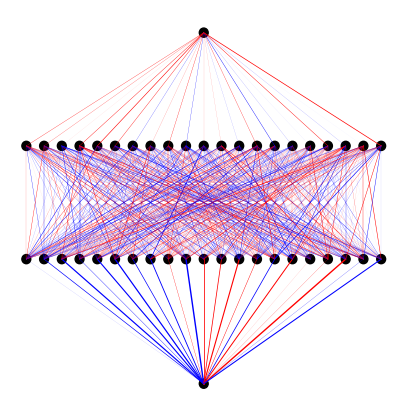

In [43]:
model.plot()
plt.show()

### BIMT PINN Training

This a foor loop with *steps* epochs
It plots the PINN architecture at different steps

step = 0 | total loss: 1.90e+02 | train loss: 1.89e+02 | reg: 3.74e+01 | test error: 3.57e+00 


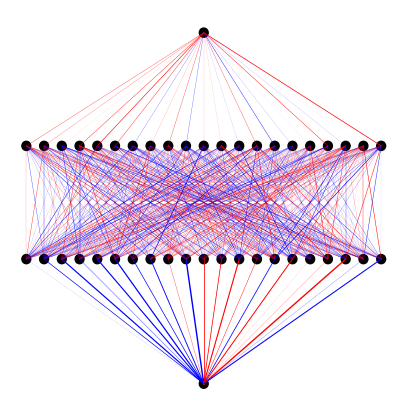

step = 100 | total loss: 1.40e+02 | train loss: 1.40e+02 | reg: 4.77e+01 | test error: 9.48e-01 
step = 200 | total loss: 1.03e+02 | train loss: 1.03e+02 | reg: 5.23e+01 | test error: 7.53e-01 
step = 300 | total loss: 1.87e+01 | train loss: 1.86e+01 | reg: 6.41e+01 | test error: 1.13e+01 
step = 400 | total loss: 6.02e+00 | train loss: 5.95e+00 | reg: 6.52e+01 | test error: 8.27e+00 
step = 500 | total loss: 2.72e+00 | train loss: 2.66e+00 | reg: 6.77e+01 | test error: 8.57e+00 
step = 600 | total loss: 1.23e+00 | train loss: 1.16e+00 | reg: 6.93e+01 | test error: 4.81e+00 
step = 700 | total loss: 7.46e-01 | train loss: 6.75e-01 | reg: 7.06e+01 | test error: 3.40e+00 
step = 800 | total loss: 4.88e-01 | train loss: 4.18e-01 | reg: 7.07e+01 | test error: 2.59e+00 
step = 900 | total loss: 3.86e-01 | train loss: 3.15e-01 | reg: 7.10e+01 | test error: 2.09e+00 
step = 1000 | total loss: 3.06e-01 | train loss: 2.36e-01 | reg: 7.04e+01 | test error: 1.65e+00 
step = 1100 | total loss: 2.5

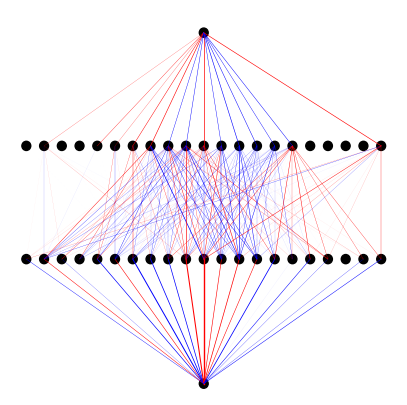

step = 25100 | total loss: 2.43e-01 | train loss: 9.22e-04 | reg: 2.42e+01 | test error: 1.13e-03 
step = 25200 | total loss: 2.38e-01 | train loss: 1.04e-03 | reg: 2.37e+01 | test error: 1.33e-03 
step = 25300 | total loss: 2.37e-01 | train loss: 3.67e-03 | reg: 2.33e+01 | test error: 8.23e-04 
step = 25400 | total loss: 2.31e-01 | train loss: 2.11e-03 | reg: 2.29e+01 | test error: 7.72e-04 
step = 25500 | total loss: 2.27e-01 | train loss: 9.09e-04 | reg: 2.26e+01 | test error: 9.93e-04 
step = 25600 | total loss: 2.24e-01 | train loss: 2.11e-03 | reg: 2.22e+01 | test error: 1.06e-03 
step = 25700 | total loss: 2.21e-01 | train loss: 2.43e-03 | reg: 2.19e+01 | test error: 1.10e-03 
step = 25800 | total loss: 2.17e-01 | train loss: 1.21e-03 | reg: 2.16e+01 | test error: 8.12e-04 
step = 25900 | total loss: 2.15e-01 | train loss: 1.02e-03 | reg: 2.14e+01 | test error: 1.27e-03 
step = 26000 | total loss: 2.14e-01 | train loss: 1.00e-03 | reg: 2.13e+01 | test error: 1.07e-03 
step = 261

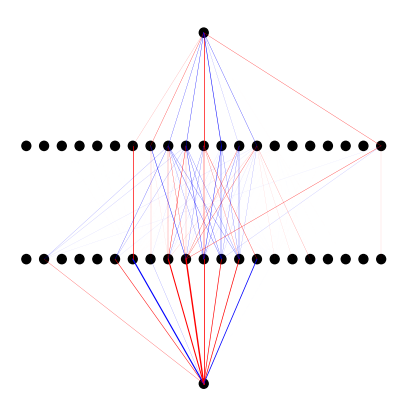

step = 50100 | total loss: 1.05e-01 | train loss: 1.71e-03 | reg: 1.03e+01 | test error: 8.50e-05 
step = 50200 | total loss: 1.06e-01 | train loss: 2.54e-03 | reg: 1.03e+01 | test error: 1.22e-04 
step = 50300 | total loss: 1.04e-01 | train loss: 1.38e-03 | reg: 1.03e+01 | test error: 6.39e-05 
step = 50400 | total loss: 1.07e-01 | train loss: 4.48e-03 | reg: 1.03e+01 | test error: 5.02e-05 
step = 50500 | total loss: 1.08e-01 | train loss: 5.50e-03 | reg: 1.03e+01 | test error: 6.07e-05 
step = 50600 | total loss: 1.04e-01 | train loss: 1.34e-03 | reg: 1.03e+01 | test error: 6.12e-05 
step = 50700 | total loss: 1.08e-01 | train loss: 4.90e-03 | reg: 1.03e+01 | test error: 5.24e-05 
step = 50800 | total loss: 1.04e-01 | train loss: 1.77e-03 | reg: 1.03e+01 | test error: 9.06e-05 
step = 50900 | total loss: 1.05e-01 | train loss: 2.33e-03 | reg: 1.02e+01 | test error: 1.07e-04 
step = 51000 | total loss: 1.08e-01 | train loss: 5.29e-03 | reg: 1.02e+01 | test error: 2.08e-04 
step = 511

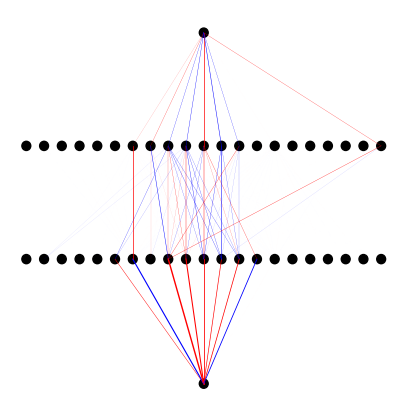

step = 75100 | total loss: 1.21e-02 | train loss: 1.72e-03 | reg: 1.04e+01 | test error: 8.03e-05 
step = 75200 | total loss: 1.23e-02 | train loss: 1.88e-03 | reg: 1.04e+01 | test error: 3.53e-05 
step = 75300 | total loss: 3.31e-02 | train loss: 2.27e-02 | reg: 1.04e+01 | test error: 2.79e-04 
step = 75400 | total loss: 1.16e-02 | train loss: 1.19e-03 | reg: 1.04e+01 | test error: 6.48e-05 
step = 75500 | total loss: 1.16e-02 | train loss: 1.18e-03 | reg: 1.04e+01 | test error: 6.39e-05 
step = 75600 | total loss: 2.14e-02 | train loss: 1.10e-02 | reg: 1.04e+01 | test error: 3.81e-04 
step = 75700 | total loss: 1.15e-02 | train loss: 1.15e-03 | reg: 1.04e+01 | test error: 6.49e-05 
step = 75800 | total loss: 1.22e-02 | train loss: 1.79e-03 | reg: 1.04e+01 | test error: 1.03e-04 
step = 75900 | total loss: 1.15e-02 | train loss: 1.13e-03 | reg: 1.04e+01 | test error: 6.53e-05 
step = 76000 | total loss: 1.16e-02 | train loss: 1.18e-03 | reg: 1.04e+01 | test error: 7.04e-05 
step = 761

In [44]:
for step in range(steps):
    
    # Lambda changes in three different phases: lamda = 0.001 --> 0.01 --> 0.1
    if step == int(steps/4): 
        lamb *= 10 # change lambda
        print("Lambda Change at step: ", step)
    

    
    if step == int(3*steps/4):
        lamb *= 0.1 # change lambda
        print("Lambda Change at step: ", step)
    
    optimizer.zero_grad()
    
    ####################
    # Calculate the loss
    ####################
    
    # 1. Inner domain points
    pred  = model(inputs)
    # first derivative
    du = ag.grad(pred, inputs, torch.ones_like(pred), create_graph=True)[0]
    # second derivative
    d2u = ag.grad(du, inputs, torch.ones_like(du), create_graph=True)[0]
    res = d2u - source_term(inputs)
    
    # 2. Left BC
    pred  = model(inputsBC0)
    res0 = pred

    # 3. Right BC
    pred  = model(inputsBC1)
    res1 = pred

    # the loss function has three parts: collocation points + BC0 + BC1
    loss = torch.mean(res**2) + torch.mean(res0**2) + torch.mean(res1**2)
    
    #calculate test
    pred_test = model(inputs_test)
    test_error = np.mean((pred_test.detach().numpy() - Analytical_sol)**2)


    # history
    hist_train_loss.append(loss.detach().numpy())
    hist_test_error.append(test_error )
    
    # do not penalize bias at first (this makes the weight graph look better)
    if step < int(3*steps/4):
        reg = model.get_cc(bias_penalize=False, weight_factor=weight_factor) # No bias penalization
    else:
        reg = model.get_cc(bias_penalize=True, weight_factor=weight_factor) # Bias penalization
    #reg = model.get_cc(bias_penalize=True)
    total_loss = loss + lamb*reg
    
    # record total loss and regularization
    hist_tot_loss.append(total_loss.detach().numpy())
    hist_reg.append(reg.detach().numpy())

    total_loss.backward()
    optimizer.step()
    
    if step % log == 0:
        print("step = %d | total loss: %.2e | train loss: %.2e | reg: %.2e | test error: %.2e "%(step, total_loss.detach().numpy(), loss.detach().numpy(), reg.detach().numpy(),test_error))
    
    if (step+1) % swap_log == 0:
        model.relocate()
        

    if step % plot_log == 0:
        model.plot()
        plt.show()

**Training Done**

plot the final architecture

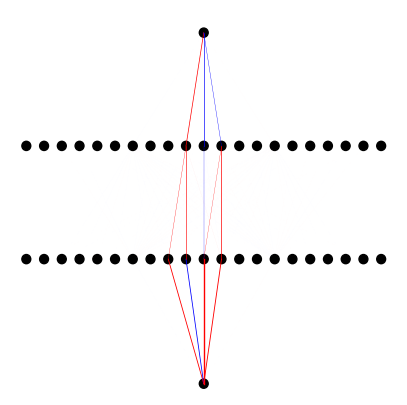

In [17]:
model.plot()
plt.show()

Make a final pruning of the weights and biases

In [18]:
# Make it fully sparse
model.thresholding(threshold=1E-3,checkpoint=False)

tensor(22)

Plot the history of different losses. Note the different phases of the training when the lambda and penalization change.

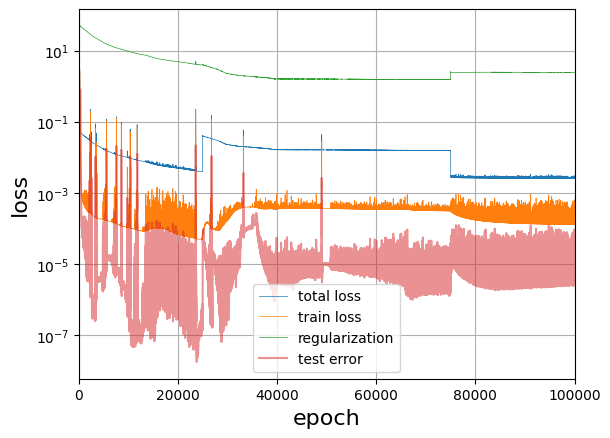

In [19]:
# plot loss function
epoch = np.linspace(1,steps,steps)
plt.semilogy(epoch, hist_tot_loss, linewidth=0.5, label="total loss") 
plt.semilogy(epoch, hist_train_loss, linewidth=0.5, label="train loss") 
plt.semilogy(epoch, hist_reg, linewidth=0.5,label="regularization") 
plt.semilogy(epoch, hist_test_error, alpha=0.5, label="test error") 
plt.xlabel("epoch", fontsize=16)
plt.ylabel("loss", fontsize=16)
plt.legend()
plt.xlim([0,steps])
plt.grid()
plt.show()

Compare the analytical solution and PINN solution.

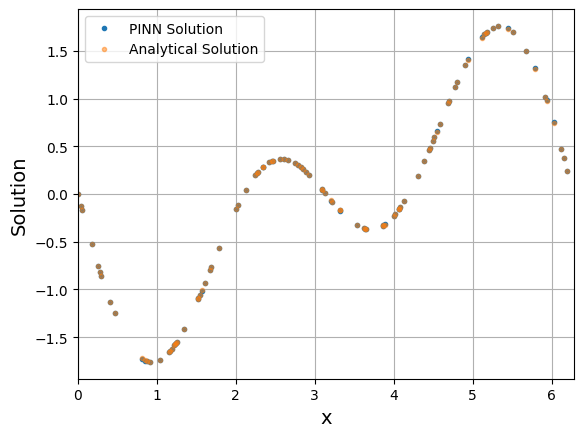

In [20]:
pred_test = model(inputs_test)
plt.plot(inputs_test.detach().numpy(), pred_test.detach().numpy(),'.',label="PINN Solution")
plt.plot(inputs_test.detach().numpy(), Analytical_sol ,'.', alpha=0.5, label="Analytical Solution")
#plt.plot(inputs_test12.detach().numpy(), pred_test12.detach().numpy(),'.',label="PINN Gen. Solution")
plt.xlabel("x", fontsize=14)
plt.ylabel("Solution", fontsize=14)
plt.legend()
plt.xlim([0,2*np.pi])
plt.grid()
plt.show()

Calculate L2 error of the PINN solution

In [21]:
PINN_sol = pred_test.detach().numpy() 
print("Error (Euclidean Norm): ",np.linalg.norm(PINN_sol-Analytical_sol))

Error (Euclidean Norm):  0.018484425


Print the weights and biases of the final PINN - *full precision*

In [23]:
torch.set_printoptions(precision=10)
# print the weights and biases
for name, param in model.named_parameters():
  print(name)
  print(param.data)

in_perm
tensor([0.])
out_perm
tensor([0.])
linears.0.linear.weight
tensor([[ 0.0000000000],
        [-0.0000000000],
        [ 0.0000000000],
        [-0.0000000000],
        [ 0.0000000000],
        [ 0.0000000000],
        [-0.0000000000],
        [-0.0000000000],
        [ 0.5705066323],
        [-0.5370593071],
        [ 0.9470548034],
        [ 0.5947775245],
        [-0.0000000000],
        [-0.0000000000],
        [ 0.0000000000],
        [ 0.0000000000],
        [ 0.0000000000],
        [ 0.0000000000],
        [ 0.0000000000],
        [ 0.0000000000],
        [-0.0000000000]])
linears.0.linear.bias
tensor([ 0.0000000000,  0.0000000000, -0.0000000000,  0.0000000000,
        -0.0000000000,  0.0000000000,  0.0000000000,  0.0000000000,
        -1.3589568138,  0.7347847819, -0.7477640510, -1.8531508446,
        -0.0000000000, -0.0000000000,  0.0000000000, -0.0000000000,
         0.0000000000,  0.0000000000, -0.0000000000,  0.0000000000,
         0.0000000000])
linears.1.linear.weig